In [1]:
#Import the required libraries
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### We will use Age, Trestbps(Blood preasure), and thalach(Maximum Heart Rate). 

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
colmns_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restceg", "max_heart_rate",
               "exang", "oldpeak", "slope", "ca", "thal", "heart_disease")


heart_data <- read_csv(url, col_names = colmns_names)|>
    #Change the data type in the columns to the necessary data type for our classification
    mutate(across(c(trestbps, fbs, restceg, max_heart_rate, exang, oldpeak, slope, ca, thal),
                as.numeric),
          heart_disease = ifelse(heart_disease == "1" | heart_disease == "2" | 
                                 heart_disease == "3" | heart_disease == "4", "True", heart_disease),
          heart_disease = ifelse(heart_disease == "0", "False", heart_disease),
          heart_disease = as.factor(heart_disease))
# Preview the first 10 observations
head(heart_data, n=10)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restceg, max_heart_rate, exang,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restceg,max_heart_rate,exang,oldpeak,slope,ca,thal,heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,False
67,1,4,160,286,0,2,108,1,1.5,2,3,3,True
67,1,4,120,229,0,2,129,1,2.6,2,2,7,True
37,1,3,130,250,0,0,187,0,3.5,3,0,3,False
41,0,2,130,204,0,2,172,0,1.4,1,0,3,False
56,1,2,120,236,0,0,178,0,0.8,1,0,3,False
62,0,4,140,268,0,2,160,0,3.6,3,2,3,True
57,0,4,120,354,0,0,163,1,0.6,1,0,3,False
63,1,4,130,254,0,2,147,0,1.4,2,1,7,True


In [3]:
set.seed(1)
heart_data <- heart_data |>
    select(age, trestbps, max_heart_rate, heart_disease)
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

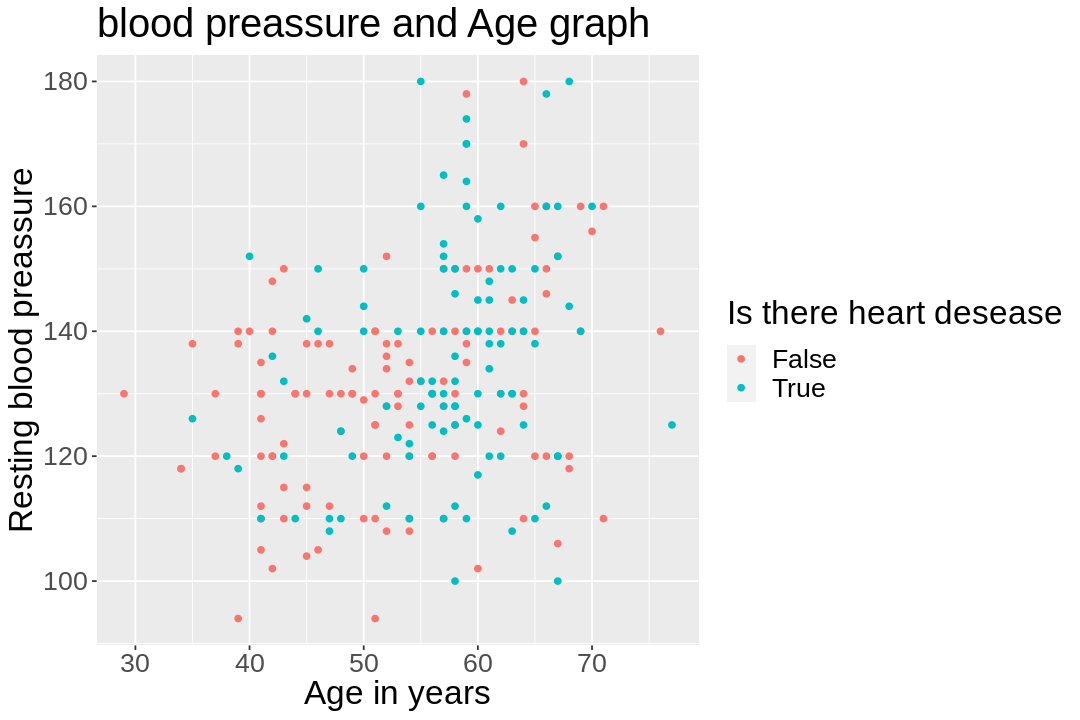

In [4]:
options(repr.plot.width=9, repr.plot.height=6)
age_trestbps_plot <- heart_train |>
    ggplot(aes(x = age, y = trestbps)) +
        geom_point(aes(color = heart_disease)) +
        labs (x = "Age in years", y = "Resting blood preassure", color = "Is there heart desease", title = "blood preassure and Age graph")+
        theme(text = element_text(size=20))
age_trestbps_plot


### Performing Classification with $k$-nearest algorithm, k=3

* First, we try with $k$=3 

In [5]:
set.seed(10)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")
heart_recipe <- recipe(heart_disease ~ age + trestbps + max_heart_rate, data= heart_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())
heart_fit <- workflow()|>
    add_recipe(heart_recipe)|>
    add_model(knn_spec)|>
    fit(data = heart_train)
heart_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3876652
Best kernel: rectangular
Best k: 3

#### Now, we perform 10-fold cross-validation to get the best $k$ value possible

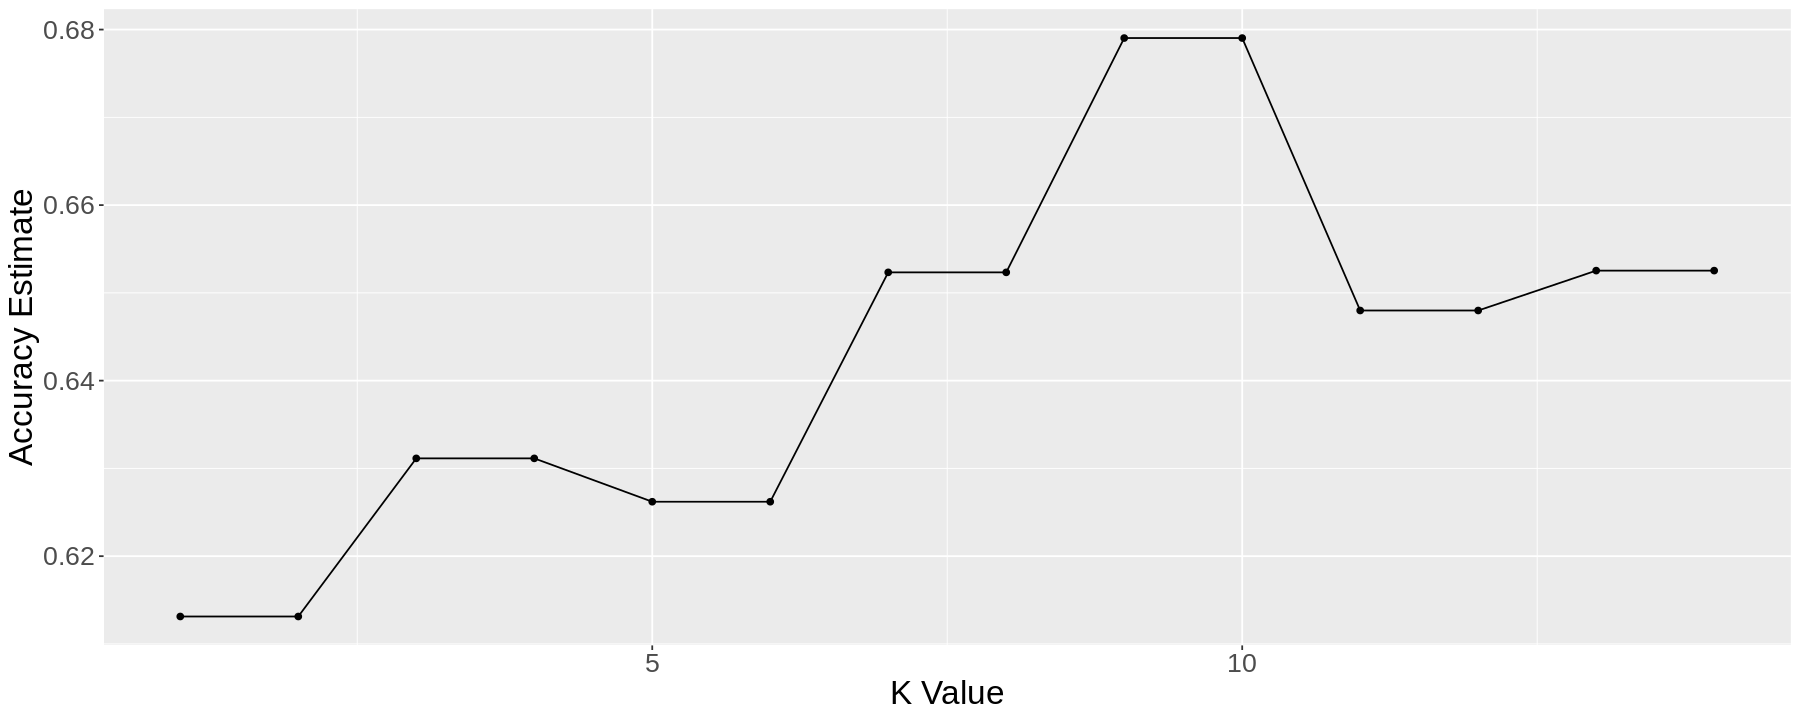

In [18]:
set.seed(100)
options(repr.plot.width=15, repr.plot.height=6)

heart_vfold <- vfold_cv(heart_train, v = 10, strata = heart_disease)
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_resamples_fit <- workflow()|>
    add_recipe(heart_recipe)|>
    add_model(knn_best_spec)|>
    tune_grid(resamples = heart_vfold, grid=20)|>
    collect_metrics()|>
    filter(.metric == "accuracy")

accuracy_v_k_plot <- heart_resamples_fit |>
    ggplot(aes(x= neighbors, y= mean))+
        geom_point()+
        geom_line()+
        labs(x= "K Value", y= "Accuracy Estimate")+
        theme(text = element_text(size=20))
accuracy_v_k_plot

* We observe from the graph above that the best $k$ values are $k=9$ or $k=10$. For this classification, we will chose $k=10$. Now, we perform $k$-nearest neighbors classification with $k=10$. 

In [20]:
knn_spec_10 <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_best_fit <- workflow()|>  
    add_recipe(heart_recipe)|>
    add_model(knn_spec_10)|>
    fit(data = heart_train)

heart_best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3348018
Best kernel: rectangular
Best k: 10

In [22]:
heart_test_predections <- predict(heart_best_fit, heart_test)|>
    bind_cols(heart_test)
head(heart_test_predections, n=10)

.pred_class,age,trestbps,max_heart_rate,heart_disease
<fct>,<dbl>,<dbl>,<dbl>,<fct>
False,56,120,178,False
True,62,140,160,True
False,57,120,163,False
False,44,120,173,False
True,52,172,162,False
False,54,140,160,False
False,48,130,139,False
False,58,120,160,True
False,50,120,158,False


In [23]:
heart_test_accuracy <- heart_test_predections |>
    metrics(truth = heart_disease, estimate = .pred_class)
heart_test_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7236842
kap,binary,0.4356436


In [24]:
heart_matrix <- heart_test_predections |>
    conf_mat(truth = heart_disease, estimate = .pred_class)
heart_matrix

          Truth
Prediction False True
     False    34   14
     True      7   21

We have $55$ correctly labelled values.